# Necessary Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from multimode_expts.analysis_notebooks.expts_run_base import *

Warning serial library import failed.
Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver


In [36]:
expts_base_inst = expts_run_base(data_path=r'H:\Shared drives\SLab\Multimode\experiment\250505_craqm', 
                            config_name='hardware_config_202505.yml',
                              exp_param_name='experiment_config.yml', qubit_i=0)

path:  H:\Shared drives\SLab\Multimode\experiment\250505_craqm
Data will be stored in H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data
Hardware configs will be read from C:\_Lib\python\multimode_expts\configs\hardware_config_202505.yml
Experiment params will be read from C:\_Lib\python\multimode_expts\configs\experiment_config.yml
<Pyro4.core.Proxy at 0x2378446f760; not connected; for PYRO:obj_60f1dbe4d66e49e4a42ce8f10a5bd4b8@192.168.137.101:35093>
Path added at highest priority
['C:\\_Lib\\python\\multimode_expts', 'C:\\_Lib\\python\\multimode_expts', 'C:\\_Lib\\python\\multimode_expts', 'C:\\_Lib\\python', 'C:\\_Lib\\python\\slab', 'C:\\_Lib\\python\\qick\\qick_lib', 'C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts', 'c:\\_Lib\\python\\multimode_expts\\analysis_notebooks\\bosonic', 'c:\\Users\\26049\\.conda\\envs\\slab\\python38.zip', 'c:\\Users\\26049\\.conda\\envs\\slab\\DLLs', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib', 'c:\\Users\\26049\\.conda\\envs\\slab', 

In [4]:
expts_base_inst.path

'H:\\Shared drives\\SLab\\Multimode\\experiment\\250505_craqm'

# Characterization

## Parity Delay

In [18]:
def do_parity_delay(
    config_thisrun,
    expt_path,
    config_path,
    start=0.01,
    step=0.05,
    expts=100,
    reps=200,
    rounds=1,
    qubits=[0],
    prepulse=True,
    normalize=False,
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    pre_gate_sweep_pulse=[],
    man_mode_no=1,
    relax_delay=2500
):
    """Run the Parity Delay experiment with configurable parameters."""
    from MM_dual_rail_base import MM_dual_rail_base
    mm_base_dummy = MM_dual_rail_base(config_thisrun)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    expt_cfg = {
        'start': start,
        'step': step,
        'expts': expts,
        'reps': reps,
        'rounds': rounds,
        'qubits': qubits,
        'prepulse': prepulse,
        'normalize': normalize,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'pre_sweep_pulse': [],
        'pre_gate_sweep_pulse': prep_man_pi
    }
    # print("expt_path:", expt_path)
    # print("config_path:", config_path)
    
    
    parity_delay_exp = expts_base_inst.meas.single_qubit.parity_delay.ParityDelayExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='ParityDelayExperiment', config_file=config_path
    )
    parity_delay_exp.cfg = AttrDict(deepcopy(config_thisrun))
    parity_delay_exp.cfg.expt = expt_cfg
    parity_delay_exp.cfg.device.readout.relax_delay = [relax_delay] 
    parity_delay_exp.go(analyze=False, display=False, progress=True, save=True)
    return parity_delay_exp


In [40]:
parity_delay_exp = do_parity_delay(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file)

  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00002_ParityDelayExperiment.h5


Attempted to init fitparam 2 to -500, which is out of bounds -360 to 360. Instead init to 0.0
p1: 0.29146551235622287
p2: -77.59835390362066
Pi length: 1.5972763957631686
Pi/2 length: 0.739541983279899
p1: 0.28959159021035424
p2: 108.85068447526264
Pi length: 1.545752717624014
Pi/2 length: 0.6824679799063048


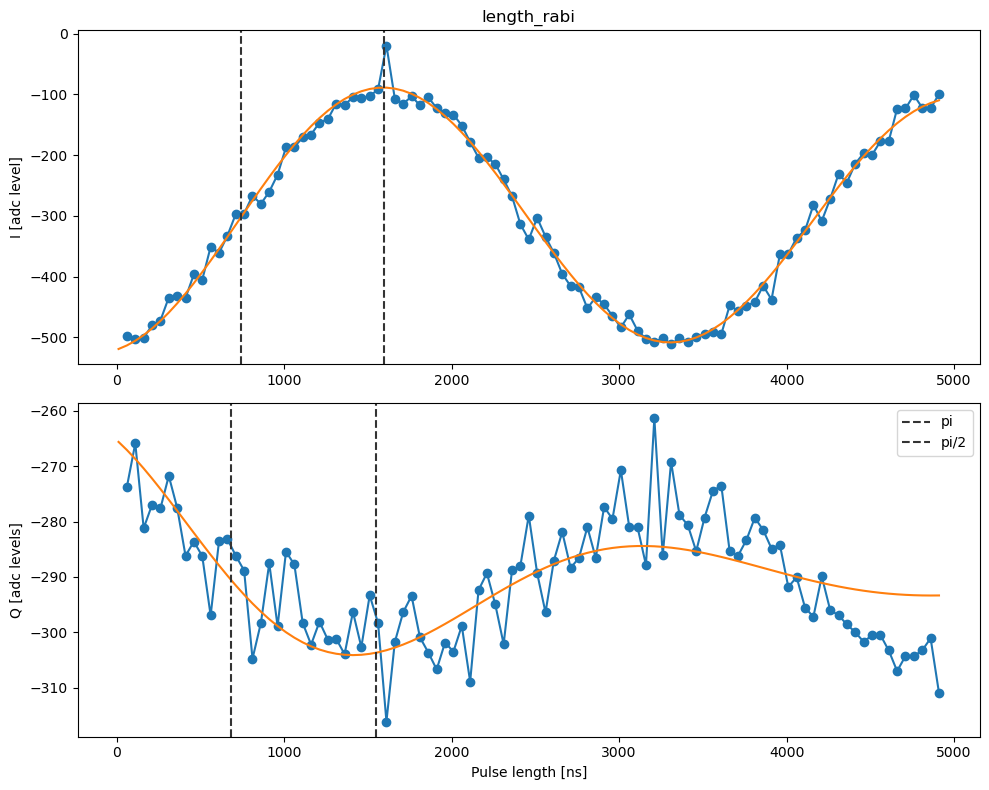

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-12_14-51-03_Length_Rabi_General_F0g1.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-12.md


In [41]:
from multimode_expts.fit_display_classes import LengthRabiFitting
# Analyze the data
length_rabi_analysis = LengthRabiFitting(parity_delay_exp.data, config = parity_delay_exp.cfg)
length_rabi_analysis.analyze(fitparams = [500, 0.05, -500, None, None, None])
length_rabi_analysis.display(title_str='Length Rabi General F0g1')

In [43]:
## Assign to config 
expts_base_inst.config_thisrun.device.manipulate.revival_time[0] = length_rabi_analysis.results['pi_length']

## Manipulate SPectroscopy

In [49]:
def do_cavity_spectroscopy(
    config_thisrun,
    expt_path,
    config_path,
    start=4980,
    step=0.01,
    expts=1000,
    reps=100,
    pulse_e=False,
    pulse_f=False,
    cavity_name='manipulate',
    drive_gain=500,
    qubit=0,
    RF_modulation=[False, 1055, 5000, 'high'],
    relax_delay=200
):
    """Run the Cavity Spectroscopy experiment with configurable parameters."""
    expt_cfg = {
        'start': start,
        'step': step,
        'expts': expts,
        'reps': reps,
        'pulse_e': pulse_e,
        'pulse_f': pulse_f,
        'cavity_name': cavity_name,
        'drive_gain': drive_gain,
        'qubit': qubit,
        'RF_modulation': RF_modulation
    }
    cavity_spec_exp = expts_base_inst.meas.single_qubit.cavity_spectroscopy.CavitySpectroscopyExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='CavitySpectroscopyExperiment', config_file=config_path
    )
    cavity_spec_exp.cfg = AttrDict(deepcopy(config_thisrun))
    cavity_spec_exp.cfg.expt = expt_cfg
    cavity_spec_exp.cfg.device.readout.relax_delay = [relax_delay]
    cavity_spec_exp.go(analyze=True, display=True, progress=True, save=True)
    return cavity_spec_exp


def update_res_spec(rspec, config_thisrun):
    config_thisrun.device.manipulate.f_ge[0] = [rspec.data['fit'][0]]
    print('Updated man_freq frequency!')

In [50]:
do_cavity_spectroscopy(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    start=4980,
    step=0.01,
    expts=1000,
    reps=100,
    drive_gain=500,
    pulse_e=False,
    pulse_f=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

AttributeError: 'AttrDict' object has no attribute 'readout_length'

# Save Config

In [44]:
expts_base_inst.recursive_compare(expts_base_inst.yaml_cfg, expts_base_inst.config_thisrun)

Key 'device.manipulate.revival_time' differs:
  Old value (config1): [1.8471786686909633, 1.7366205852286094]
  New value (config2): [1.5972763957631686, 1.7366205852286094]


In [46]:
expts_base_inst.handle_config_update(updateConfig_bool=True)

Comparing configurations:
Key 'device.manipulate.revival_time' differs:
  Old value (config1): [1.8471786686909633, 1.7366205852286094]
  New value (config2): [1.5972763957631686, 1.7366205852286094]
Directory created for autocalibration plots at: H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\autocalibration_plots_2025-06-12
Configuration updated and saved, excluding storage_man_file. 
!!!!Please set updateConfig to False after this run!!!!!!.
